## Benchmark Model

### Import Dataset

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train and validation datasets
breed_path = "plant/train/"
valid_path = "plant/valid/"

def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

# load train and validation datasets
train_files, train_targets = load_dataset(breed_path)
valid_files, valid_targets = load_dataset(valid_path)


# load list of plant names
plant_names = [item[28:-1] for item in sorted(glob(breed_path+"*/"))]

# print statistics about the dataset
print('There are %d total plant categories.' % len(plant_names))
print('There are %d training plant images.' % len(train_files))
print('There are %d validation plant images.' % len(valid_files))

There are 12 total plant categories.
There are 3801 training plant images.
There are 949 validation plant images.


### Pre-process the Data

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from tqdm import tqdm
from PIL import ImageFile    


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 949/949 [00:20<00:00, 47.06it/s]


### Model Architecture

In [5]:
# weights.best.hdf5
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=10, kernel_size=3, padding='same', activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=30, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=60, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(12, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 10)      280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 30)        2730      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 60)        16260     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 60)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
__________

In [6]:
from sklearn.metrics import f1_score
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


### Train model

In [17]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

# defines model checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 3801 samples, validate on 949 samples
Epoch 1/10
3801/3801 [==============================] - 13s 4ms/step - loss: 1.9856 - acc: 0.3165 - val_loss: 3.4652 - val_acc: 0.1992
Epoch 2/10
3801/3801 [==============================] - 9s 2ms/step - loss: 1.2709 - acc: 0.5735 - val_loss: 1.4357 - val_acc: 0.5332
Epoch 3/10
3801/3801 [==============================] - 9s 2ms/step - loss: 0.9832 - acc: 0.6672 - val_loss: 1.1258 - val_acc: 0.6554
Epoch 4/10
3801/3801 [==============================] - 9s 2ms/step - loss: 0.8070 - acc: 0.7280 - val_loss: 1.1506 - val_acc: 0.6596
Epoch 5/10
3801/3801 [==============================] - 9s 2ms/step - loss: 0.6624 - acc: 0.7780 - val_loss: 0.8370 - val_acc: 0.7345
Epoch 6/10
3801/3801 [==============================] - 9s 2ms/step - loss: 0.5316 - acc: 0.8253 - val_loss: 0.6875 - val_acc: 0.7808
Epoch 7/10
3801/3801 [==============================] - 9s 2ms/step - loss: 0.4463 - acc: 0.8485 - val_loss: 0.7629 - val_acc: 0.7871
Epoch 8/10
380

In [8]:
from sklearn.metrics import f1_score
model.load_weights('saved_models/weights.best.hdf5')
plant_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report accuracy and f1 score of the validation data
validation_accuracy = 100*np.sum(np.array(plant_predictions)==np.argmax(valid_targets, axis=1))/len(plant_predictions)
f1_test = f1_score(np.argmax(valid_targets, axis=1), np.array(plant_predictions), average='micro')
print('validation accuracy: %.4f%%, f1 score: %.4f' % (validation_accuracy, f1_test))

validation accuracy: 78.0822%, f1 score: 0.7808


### Visual representation of the predicted result for the validation dataset

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
from collections import Counter
count = Counter(plant_predictions)
breed_count = {}
for i in range(len(plant_names)):
    breed_count[plant_names[i]] = count[i]

In [18]:
breed_count

{'Black-grass': 29,
 'Charlock': 76,
 'Cleavers': 63,
 'Common Chickweed': 143,
 'Common wheat': 42,
 'Fat Hen': 89,
 'Loose Silky-bent': 162,
 'Maize': 38,
 'Scentless Mayweed': 99,
 'Shepherds Purse': 64,
 'Small-flowered Cranesbill': 75,
 'Sugar beet': 69}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

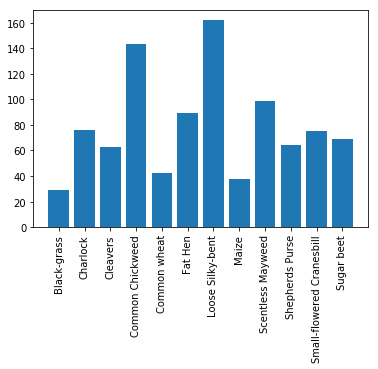

In [19]:
plt.bar(breed_count.keys(), breed_count.values())
plt.xticks(rotation=90)